# SE-2200E Notebook 4: A First Prediction

Ningsong Shen

February 18, 2021

## Summary

Using our cleaned data, we separate into train, test, validate sets and run some simple algorithms

## Model Usage
Get a trained model paramaters and use it to predict live data from transit feeds using the AWS vm.

In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv('../clean_data/sample_data.csv').drop_duplicates().sort_values(["trip_id", "start_date", "stop_sequence"], ignore_index=True)
df.shape

(861, 7)

In [4]:

df['trip_id'] = df['trip_id'].astype('category')
df.head()

,trip_id,start_date,route_id,stop_sequence,realtime_departure_time,vehicle_id,scheduled_departure_time
0,1346803,20201104,24,41,1604508849,3140.0,11:53:34
1,1346803,20201104,24,42,1604508850,3140.0,11:54:13
2,1346803,20201104,24,43,1604508889,3140.0,11:55:07
3,1346803,20201104,24,44,1604508928,3140.0,11:55:47
4,1346803,20201104,24,45,1604508982,3140.0,11:56:15


In [5]:
df.dtypes

trip_id                     category
start_date                     int64
route_id                       int64
stop_sequence                  int64
realtime_departure_time        int64
vehicle_id                   float64
scheduled_departure_time      object
dtype: object

## More Data Cleaning

To do a linear regression, we need to convert all the dates and times into a numeric value. We will use seconds from the departure time.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [8]:
df1 = pd.read_csv('../raw_data/schedule/stop_times.txt')

In [9]:
df2 = df1[df1["stop_sequence"] == 1][['trip_id', 'departure_time']].rename(columns={'departure_time': 'start_time'})
df2.head()


,trip_id,start_time
0,1342560,6:13:00
57,1342561,7:33:00
114,1342562,6:53:00
175,1342563,8:02:00
236,1342564,9:02:00


In [10]:

df2['trip_id'] = df2['trip_id'].astype('category')
df2.dtypes

trip_id       category
start_time      object
dtype: object

In [22]:
combined_df = df.merge(df2, on="trip_id", how='inner')
combined_df['real_departure_time'] = pd.to_datetime(combined_df['realtime_departure_time'],unit='s').dt.tz_localize("GMT").dt.tz_convert('America/Toronto').dt.time
combined_df.head()


,trip_id,start_date,route_id,stop_sequence,realtime_departure_time,vehicle_id,scheduled_departure_time,start_time,real_departure_time
0,1346803,20201104,24,41,1604508849,3140.0,11:53:34,11:18:00,11:54:09
1,1346803,20201104,24,42,1604508850,3140.0,11:54:13,11:18:00,11:54:10
2,1346803,20201104,24,43,1604508889,3140.0,11:55:07,11:18:00,11:54:49
3,1346803,20201104,24,44,1604508928,3140.0,11:55:47,11:18:00,11:55:28
4,1346803,20201104,24,45,1604508982,3140.0,11:56:15,11:18:00,11:56:22


In [27]:
helper = np.vectorize(lambda x: x.total_seconds())
combined_df['real_diff'] = helper(pd.to_datetime(combined_df['real_departure_time'].astype(str)).dt.to_pydatetime() - pd.to_datetime(combined_df['start_time'].astype(str)).dt.to_pydatetime())

combined_df['schedule_diff'] = helper(pd.to_datetime(combined_df['scheduled_departure_time'].astype(str)).dt.to_pydatetime() - pd.to_datetime(combined_df['start_time'].astype(str)).dt.to_pydatetime())

In [28]:
combined_df.head()

,trip_id,start_date,route_id,stop_sequence,realtime_departure_time,vehicle_id,scheduled_departure_time,start_time,real_departure_time,real_diff,schedule_diff
0,1346803,20201104,24,41,1604508849,3140.0,11:53:34,11:18:00,11:54:09,2169.0,2134.0
1,1346803,20201104,24,42,1604508850,3140.0,11:54:13,11:18:00,11:54:10,2170.0,2173.0
2,1346803,20201104,24,43,1604508889,3140.0,11:55:07,11:18:00,11:54:49,2209.0,2227.0
3,1346803,20201104,24,44,1604508928,3140.0,11:55:47,11:18:00,11:55:28,2248.0,2267.0
4,1346803,20201104,24,45,1604508982,3140.0,11:56:15,11:18:00,11:56:22,2302.0,2295.0


## A Linear Regression

In [4]:
df.dtypes

trip_id                       int64
start_date                    int64
route_id                      int64
stop_sequence                 int64
realtime_departure_time       int64
vehicle_id                  float64
scheduled_departure_time     object
dtype: object

In [30]:
X = combined_df["schedule_diff"].values.reshape(-1, 1)
Y = combined_df["real_diff"].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

Text(0, 0.5, 'Actual # of seconds from terminal')

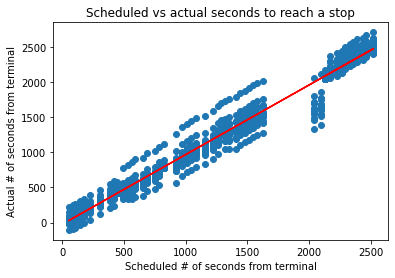

In [37]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title("Scheduled vs actual seconds to reach a stop")
plt.xlabel("Scheduled # of seconds from terminal")
plt.ylabel("Actual # of seconds from terminal")